In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from bci_dataset import BCIDataset

from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
from brainflow.data_filter import DataFilter, FilterTypes, WindowOperations, NoiseTypes

from multitask import MultitaskSSVEPClassifier

from sklearn import metrics

from tsai.models.RNN_FCN import MLSTM_FCN

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
# device = torch.device('cpu')

In [10]:
class BCIModel(nn.Module):
    def __init__(self, channels=8, classes=3):
        super(BCIModel, self).__init__()
        
        self.conv1 = nn.Conv1d(channels, 64, 3)
        self.conv2 = nn.Conv1d(64, 256, 3)
        self.conv3 = nn.Conv1d(256, 512, 3)
        self.conv4 = nn.Conv1d(512, 1024, 3)
        self.conv5 = nn.Conv1d(1024, 16, 3)
        
        self.fc1 = nn.Linear(848, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, classes)

    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        x = torch.sigmoid(self.conv5(x))
        
        x = torch.flatten(x, 1)
        
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


In [11]:
train_dataset = BCIDataset('data/train', data_length=512)
test_dataset = BCIDataset('data/test', data_length=512)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In [12]:
model = MLSTM_FCN(c_in=8, c_out=3, seq_len=128, se=16)
# model = MultitaskSSVEPClassifier(
#     num_channel=8,
#     num_classes=3,
#     signal_length=512,|
# )

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [13]:
def fwd_pass(inputs, targets, train=False):
  inputs = inputs.to(device)
  targets = targets.to(device)

  if train:
    model.zero_grad()
  
  outputs = model(inputs)
  matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, targets)]
  acc = matches.count(True) / len(matches)
  loss = loss_function(outputs, targets)

  if train:
    loss.backward()
    optimizer.step()
  
  return acc, loss

In [14]:
now = datetime.now()
dt_string = now.strftime("%d:%m:%Y-%H:%M:%S")
writer = SummaryWriter(f'runs/BCI_{dt_string}')

EPOCHS = 50
global_step = 0
for epoch in range(EPOCHS):
    progress_bar = tqdm(total=len(train_dataloader))
    progress_bar.set_description(f"Epoch {epoch + 1}/{EPOCHS}")
    
    for step, batch in enumerate(train_dataloader):
        inputs = batch['inputs']
        targets = batch['targets']
        
        acc, loss = fwd_pass(inputs, targets, train=True)
        loss = loss.detach().item()
        
        progress_bar.update(1)
        logs = {"loss": loss, "accuracy": acc, "step": global_step}
        progress_bar.set_postfix(**logs)
        
        writer.add_scalar('Loss/train', loss, global_step)
        writer.add_scalar('Accuracy/train', acc, global_step)
        
        
        global_step += 1
        
    
    test_acc_list = []
    test_loss_list = []
    for batch in test_dataloader:
        inputs = batch['inputs']
        targets = batch['targets']
        
        test_acc, test_loss = fwd_pass(inputs, targets, train=False)
        
        test_acc_list.append(test_acc)
        test_loss_list.append(test_loss.detach().item())
    
    test_acc = np.mean(test_acc_list)
    test_loss = np.mean(test_loss_list)
    
    writer.add_scalar('Loss/test', test_loss, global_step)
    writer.add_scalar('Accuracy/test', test_acc, global_step)
    
    if (epoch + 1) % 5 == 0 or epoch + 1 == EPOCHS:
        torch.save(model.state_dict(), f"models/model_{epoch + 1}.pth")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

KeyboardInterrupt: 

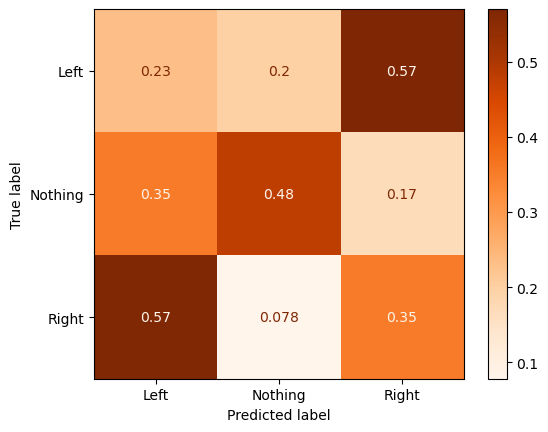

In [ ]:
model.load_state_dict(torch.load('models/model_20.pth'))

inputs = test_dataset[:]['inputs'].to(device)
targets = test_dataset[:]['targets']

with torch.no_grad():
    outputs = model(inputs)

outputs = torch.argmax(outputs, dim=1).cpu().numpy()
targets = torch.argmax(targets, dim=1).cpu().numpy()

cm = metrics.confusion_matrix(targets, outputs, normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left', 'Nothing', 'Right'])
disp.plot(cmap=plt.cm.Oranges)